In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# uncomment to disable numba
# os.environ['NOJIT'] = 'true'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import pprint
from njit_multisymbol import *
from procedures import utc_ms, load_live_config, fetch_market_specific_settings, make_get_filepath
from pure_funcs import (
    date_to_ts2,
    ts_to_date_utc,
    tuplify,
    numpyize,
    stats_multi_to_df,
    fills_multi_to_df,
    calc_drawdowns,
    calc_sharpe_ratio,
    analyze_fills_multi,
)
from njit_funcs import round_dynamic
from plotting import plot_fills_multi, plot_pnls_long_short, plot_pnls_separate, plot_pnls_stuck
from numba import njit
from downloader import load_hlc_cache, prepare_multsymbol_data

using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

### multi symbol backtest with lossless auto unstuck

- if a position is stuck, bot will use profits made on other markets to realize losses for the stuck position
- if multiple positions are stuck, select the stuck pos whose price action distance is the lowest
- each live config's individual auto unstuck is disabled

In [4]:
# select symbols for multi symbol backtest
symbols = [
    "ADAUSDT",
    "ALGOUSDT",
    "COMPUSDT",
    "LINKUSDT",
    "OMGUSDT",
    "THETAUSDT",
    "VETUSDT",
    "XTZUSDT",
]
symbols = tuple(symbols)
lcs = [
    load_live_config(f"configs/live/single_symbol_optimizations/recursive_grid/{symbol}.json")
    for symbol in symbols
]  # each symbol may have its own config

TWE_long = 2.5  # WE_limit for each symbol will be TWE / len(symbols)
TWE_short = 1.2  # WE_limit for each symbol will be TWE / len(symbols)

stuck_threshold = 0.95  # if WE / WE_limit > unstuck_threshold: consider position as stuck
unstuck_close_pct = 0.01  # max pct of balance * WE_limit to close on each unstuck order

for i in range(len(lcs)):
    lcs[i]["long"]["wallet_exposure_limit"] = TWE_long / len(symbols)
    lcs[i]["short"]["wallet_exposure_limit"] = TWE_short / len(symbols)

# convert configs to numpy matrix
live_configs = numpyize([live_config_dict_to_list_recursive_grid(lc) for lc in lcs])

In [5]:
start_date = "2021-01-01"
end_date = "now"
if end_date in ["now", "", "today"]:
    end_date = ts_to_date_utc(utc_ms())[:10]
cache_fname = make_get_filepath(
    f"tmp/cache/{'_'.join(symbols)}_{start_date}_{end_date}_hlc_cache.npy"
)
print("cache filename", cache_fname)
# prepare_multsymbol_data() is computationally expensive, so use a cache
try:
    hlcs = np.load(cache_fname)
    first_ts = 0
except:
    first_ts, hlcs = await prepare_multsymbol_data(symbols, start_date, end_date)
    np.save(cache_fname, hlcs)

cache filename tmp/cache/ADAUSDT_ALGOUSDT_COMPUSDT_LINKUSDT_OMGUSDT_THETAUSDT_VETUSDT_XTZUSDT_2021-01-01_2023-11-28_hlc_cache.npy
first ohlcv at 2019-12-31T17:00:00
fetching https://data.binance.vision/data/futures/um/daily/klines/ADAUSDT/1m/ADAUSDT-1m-2023-11-27.zip
Error during HTTP request: 404, message='Not Found', url=URL('https://data.binance.vision/data/futures/um/daily/klines/ADAUSDT/1m/ADAUSDT-1m-2023-11-27.zip')
failed to download https://data.binance.vision/data/futures/um/daily/klines/ADAUSDT/1m/ADAUSDT-1m-2023-11-27.zip 'NoneType' object is not iterable
ADAUSDT most n days of consecutive identical ohlcvs: 0.040, index last: 86519
first ohlcv at 2020-05-31T18:00:00
fetching https://data.binance.vision/data/futures/um/daily/klines/ALGOUSDT/1m/ALGOUSDT-1m-2023-11-27.zip
Error during HTTP request: 404, message='Not Found', url=URL('https://data.binance.vision/data/futures/um/daily/klines/ALGOUSDT/1m/ALGOUSDT-1m-2023-11-27.zip')
failed to download https://data.binance.vision/da

In [6]:
starting_balance = 100000.0
do_longs = tuplify([True for _ in range(len(symbols))])
do_shorts = tuplify([True for _ in range(len(symbols))])

cache_fname_mss = make_get_filepath("tmp/" + "_".join(symbols) + "_market_specific_settings.json")

mss = []
for symbol in symbols:
    cache_fname_mss = make_get_filepath(f"tmp/market_specific_settings/{symbol}.json")
    try:
        mss.append(json.load(open(cache_fname_mss)))
    except:
        print("fetching market specific settings for", symbol)
        mss_ = fetch_market_specific_settings(
            {"symbol": symbol, "exchange": "binance", "market_type": "futures"}
        )
        json.dump(mss_, open(cache_fname_mss, "w"))
        mss.append(mss_)

maker_fee = mss[0]["maker_fee"]

qty_steps = tuplify([mss[i]["qty_step"] for i in range(len(symbols))])
price_steps = tuplify([mss[i]["price_step"] for i in range(len(symbols))])
min_costs = tuplify([mss[i]["min_cost"] for i in range(len(symbols))])
min_qtys = tuplify([mss[i]["min_qty"] for i in range(len(symbols))])
c_mults = tuplify([mss[i]["c_mult"] for i in range(len(symbols))])

In [7]:
hlcs_clipped = hlcs  # [:,0:60000] # to backtest on subset on data

In [8]:
# will compile JIT on the first run, then be faster on subsequent runs
sts = utc_ms()
res = backtest_multisymbol_recursive_grid(
    hlcs_clipped,
    starting_balance,
    maker_fee,
    do_longs,
    do_shorts,
    c_mults,
    symbols,
    qty_steps,
    price_steps,
    min_costs,
    min_qtys,
    live_configs,
    stuck_threshold,
    unstuck_close_pct,
)
print(f"time elapsed {(utc_ms() - sts) / 1000:.6f}s")
fills, stats = res

time elapsed 88.791495s


In [9]:
fdf = fills_multi_to_df(fills, symbols, c_mults)
sdf = stats_multi_to_df(stats, symbols)

In [10]:
params = {"TWE_long": TWE_long, "TWE_short": TWE_short}
analysis = analyze_fills_multi(sdf, fdf, params)

In [11]:
mkl = max([len(k) for k in analysis])
for k, v in analysis.items():
    if isinstance(v, dict):
        continue
        mkls = max([len(s) for s in v])
        for symbol in v:
            mkl1 = max([len(k) for k in v[symbol]])
            for k1, v1 in v[symbol].items():
                print(f"    {symbol: <{mkls}} {k1: <{mkl1}} {round_dynamic(v1, 6)}")
            print()
    else:
        print(f"{k: <{mkl}} {round_dynamic(v, 6)}")
pd.DataFrame({k: v for k, v in analysis["individual_analyses"].items()})

n_days                     1060.0
starting_balance           100000.0
final_balance              9221480.0
final_equity               8942300.0
drawdown_max               0.525197
mean_of_10_worst_drawdowns 0.246154
adg                        0.00459045
pnl_sum                    9835110.0
pnl_long                   8718190.0
pnl_short                  1116920.0
pnl_ratio_long_short       0.886436
sum_profit_long            13311600.0
sum_profit_short           4353650.0
sum_loss_long              -4593440.0
sum_loss_short             -3236730.0
loss_profit_ratio_long     0.34507
loss_profit_ratio_short    0.743453
stuck_time_ratio_long      0.385991
stuck_time_ratio_short     0.386581
stuck_time_ratio_any       0.694784
eqbal_ratio_mean           0.957795
eqbal_ratio_min            0.439761


,ADAUSDT,ALGOUSDT,COMPUSDT,LINKUSDT,OMGUSDT,THETAUSDT,VETUSDT,XTZUSDT
pnl_ratio,6.2246445900e-02,1.1220855076e-01,1.4458956777e-01,9.5103085159e-02,1.6776667390e-01,1.0301148001e-01,1.5847861268e-01,1.5659558383e-01
pnl_ratio_long_short,8.7403990676e-01,7.0001503552e-01,1.2539712283e+00,1.2183837139e+00,8.1748205791e-01,5.4801809285e-01,9.6274060246e-01,7.0325622550e-01
pnl_long,5.3508781609e+05,7.7252503472e+05,1.7832152606e+06,1.1396144088e+06,1.3488484732e+06,5.5521317683e+05,1.5005801235e+06,1.0831094286e+06
pnl_short,7.7112853413e+04,3.3105845353e+05,-3.6116089417e+05,-2.0426506376e+05,3.0115529159e+05,4.5791610497e+05,5.8074533498e+04,4.5702543168e+05
sum_profit_long,2.1164114939e+06,1.7203373368e+06,1.9733446125e+06,1.7960415052e+06,1.7617792382e+06,1.2056835192e+06,1.5176115806e+06,1.2204266427e+06
sum_loss_long,-1.5813236778e+06,-9.4781230208e+05,-1.9012935183e+05,-6.5642709633e+05,-4.1293076491e+05,-6.5047034234e+05,-1.7031457077e+04,-1.3731721408e+05
loss_profit_ratio_long,7.4717212714e-01,5.5094560922e-01,9.6348782988e-02,3.6548548263e-01,2.3438280800e-01,5.3950338708e-01,1.1222540270e-02,1.1251574595e-01
sum_profit_short,5.0121682255e+05,6.4785875190e+05,3.5135716137e+05,4.3066752557e+05,7.4260469356e+05,5.0217852154e+05,4.9518020173e+05,6.8258628237e+05
sum_loss_short,-4.2410396914e+05,-3.1680029838e+05,-7.1251805554e+05,-6.3493258933e+05,-4.4144940197e+05,-4.4262416567e+04,-4.3710566823e+05,-2.2556085069e+05
loss_profit_ratio_short,8.4614871261e-01,4.8899593846e-01,2.0279024704e+00,1.4742987377e+00,5.9446082929e-01,8.8140799872e-02,8.8272040503e-01,3.3045031304e-01


In [12]:
sdf

,balance,equity,ADAUSDT_psize_l,ADAUSDT_pprice_l,ADAUSDT_psize_s,ADAUSDT_pprice_s,ADAUSDT_price,ALGOUSDT_psize_l,ALGOUSDT_pprice_l,ALGOUSDT_psize_s,...,LINKUSDT_WE_l,LINKUSDT_WE_s,OMGUSDT_WE_l,OMGUSDT_WE_s,THETAUSDT_WE_l,THETAUSDT_WE_s,VETUSDT_WE_l,VETUSDT_WE_s,XTZUSDT_WE_l,XTZUSDT_WE_s
minute,,,,,,,,,,,,,,,,,,,,,
0,1.0000000000e+05,1.0000000000e+05,NaN,NaN,NaN,NaN,0.18155,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,1.0003309165e+05,1.0001529671e+05,1746.0,0.18083,-1078.0,0.1804,0.18069,NaN,NaN,-862.9,...,0.0034913864,0.0030293326,0.0037393218,0.0016576946,NaN,0.0024158428,NaN,0.0023742983,0.0051671181,0.0021368689
120,1.0006499672e+05,1.0000671033e+05,NaN,NaN,-1078.0,0.1804,0.18409,NaN,NaN,-1693.1,...,NaN,0.0030283668,NaN,0.0016571661,0.0039440582,0.0024157231,NaN,0.0094461353,NaN,0.0057229123
180,1.0009768678e+05,1.0004192449e+05,NaN,NaN,-1078.0,0.1804,0.18440,NaN,NaN,-1693.1,...,NaN,0.0030273778,0.0037378029,0.0016566249,0.0039460221,0.0024149341,NaN,0.0023746043,NaN,0.0057210433
240,1.0011002190e+05,1.0003395704e+05,NaN,NaN,-1078.0,0.1804,0.18387,NaN,NaN,-2509.4,...,NaN,0.0030270047,0.0037373423,0.0016564208,0.0039467755,0.0048291065,NaN,0.0023743117,NaN,0.0057203384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526160,9.2167604654e+06,8.9502205048e+06,75769.0,0.38400,NaN,NaN,0.38400,1007227.7,0.1354075955,NaN,...,0.0104827869,0.1405936813,0.0112278937,NaN,0.0355546476,NaN,0.0271670708,NaN,0.0051928892,0.0021374292
1526220,9.2210613786e+06,8.9396548680e+06,NaN,NaN,-46373.0,0.3864,0.38740,NaN,NaN,NaN,...,0.0034925073,0.1405281052,0.0037396822,0.0016563178,0.0355380641,NaN,0.0271543995,NaN,0.0051904671,0.0021364322
1526280,9.2212196166e+06,8.9389339088e+06,NaN,NaN,-46373.0,0.3864,0.38790,347004.9,0.1370000000,NaN,...,0.0034924474,0.1405256937,0.0037396180,0.0016562894,0.0355374542,NaN,0.0271539335,NaN,0.0051903780,0.0021363956


In [13]:
fdf

,symbol,pnl,fee_paid,balance,equity,qty,price,psize,pprice,type,stuckness,cost,WE
minute,,,,,,,,,,,,,
2,ADAUSDT,0.00000,-0.063138064,9.9999936862e+04,9.9999936862e+04,1738.000,0.18164,1738.000,0.18164,long_ientry_normal,0.0101020902,315.69032,0.0031569052
2,LINKUSDT,0.00000,-0.069850836,9.9999867011e+04,9.9999380371e+04,31.020,11.25900,31.020,11.25900,long_ientry_normal,0.0111761408,349.25418,0.0034925464
2,OMGUSDT,0.00000,-0.074790768,9.9999792220e+04,9.9998343960e+04,150.800,2.47980,150.800,2.47980,long_ientry_normal,0.0119665388,373.95384,0.0037395462
2,THETAUSDT,0.00000,-0.078926652,9.9999713294e+04,9.9997571354e+04,212.100,1.86060,212.100,1.86060,long_ientry_normal,0.0126282906,394.63326,0.0039463439
2,XTZUSDT,0.00000,-0.103376560,9.9999609917e+04,9.9996577157e+04,256.900,2.01200,256.900,2.01200,long_ientry_normal,0.0165402970,516.88280,0.0051688482
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526286,COMPUSDT,0.00000,-3.106361736,9.2212165103e+06,9.2212165103e+06,-293.996,52.83000,-293.996,52.83000,short_ientry_normal,0.0112290343,15531.80868,0.0016843557
1526287,VETUSDT,0.00000,-4.379604678,9.2212121307e+06,9.2212121307e+06,-970227.000,0.02257,-970227.000,0.02257,short_ientry_normal,0.0158316229,21898.02339,0.0023747446
1526345,ADAUSDT,0.00000,-5.821886280,9.2212063088e+06,8.9435326390e+06,75063.000,0.38780,75063.000,0.38780,long_ientry_normal,0.0101017284,29109.43140,0.0031567921


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

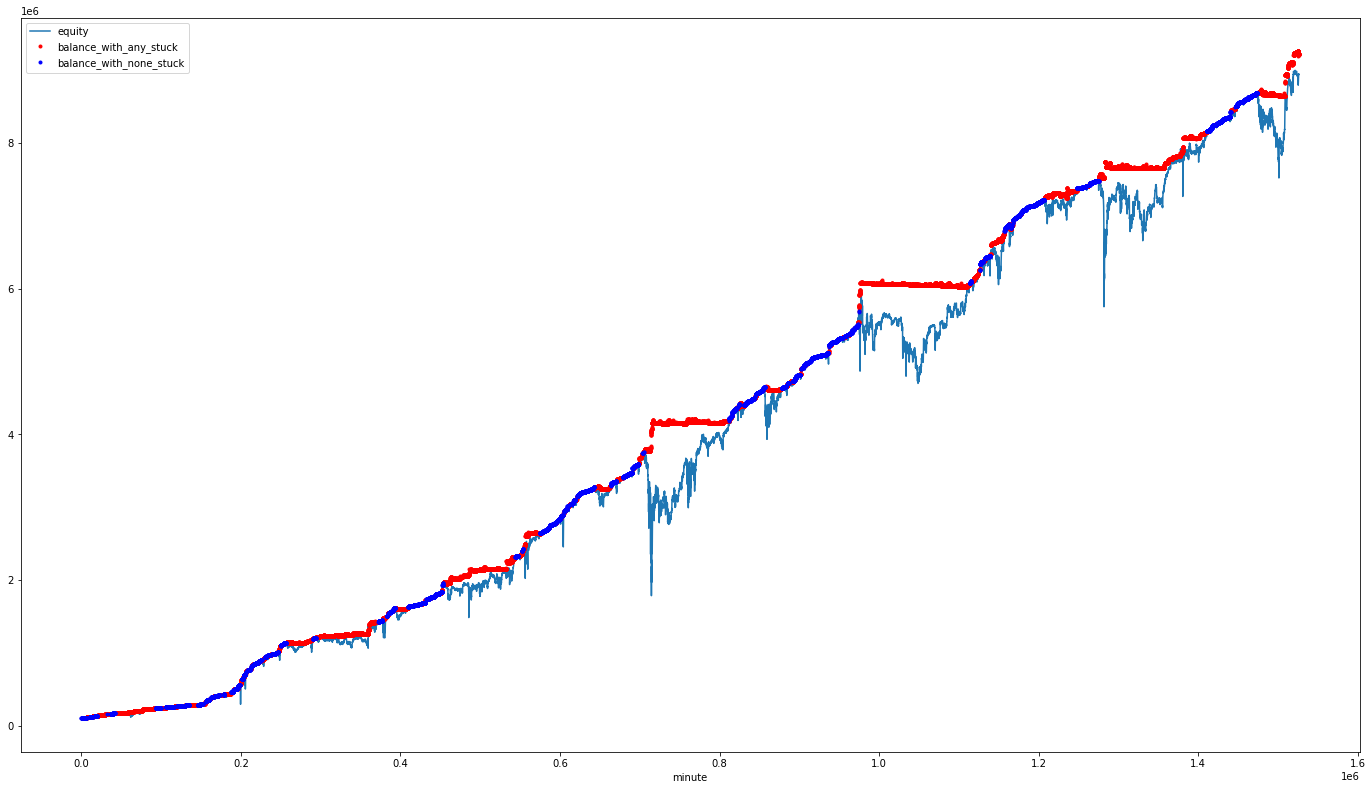

In [22]:
plot_pnls_stuck(sdf, fdf, start_pct=0.0, end_pct=1.0)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

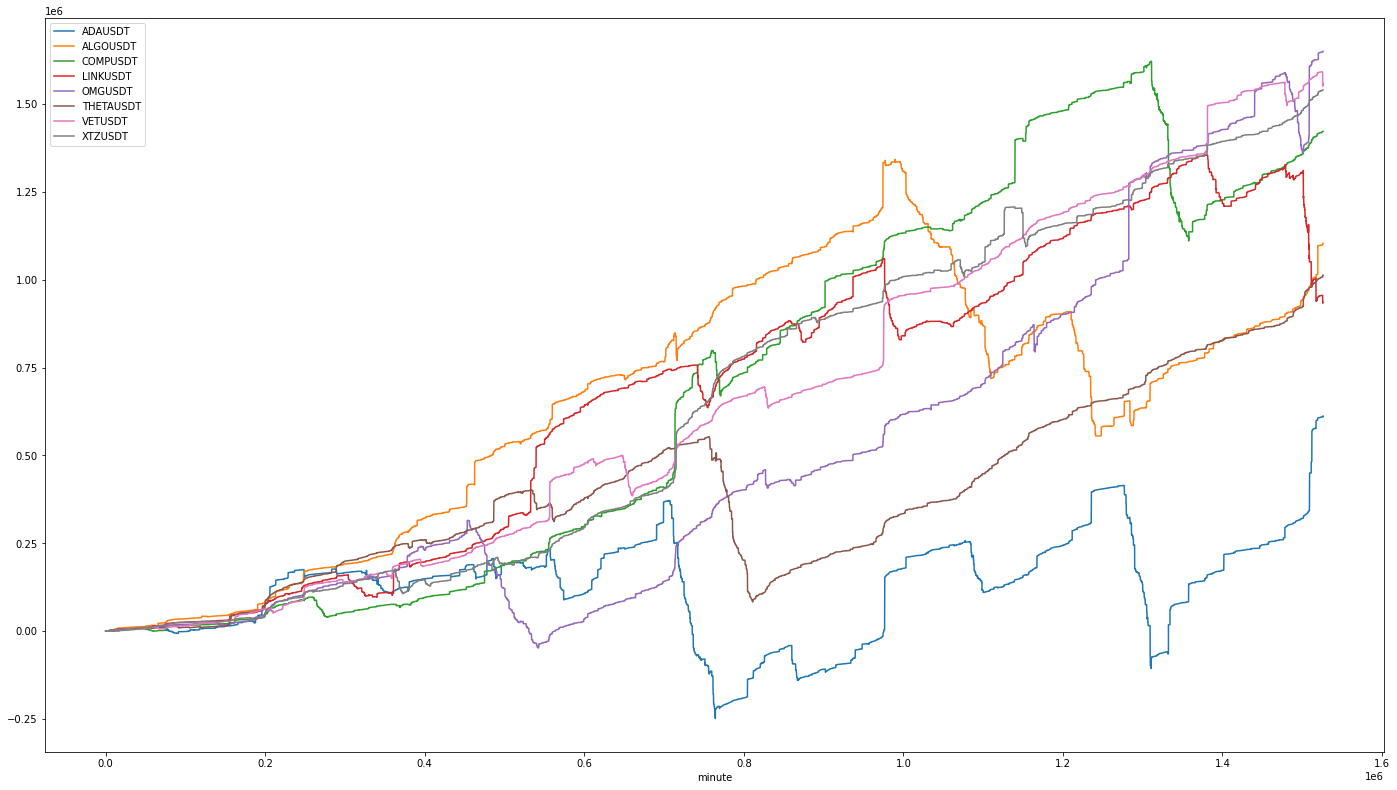

In [15]:
plot_pnls_separate(sdf, fdf)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

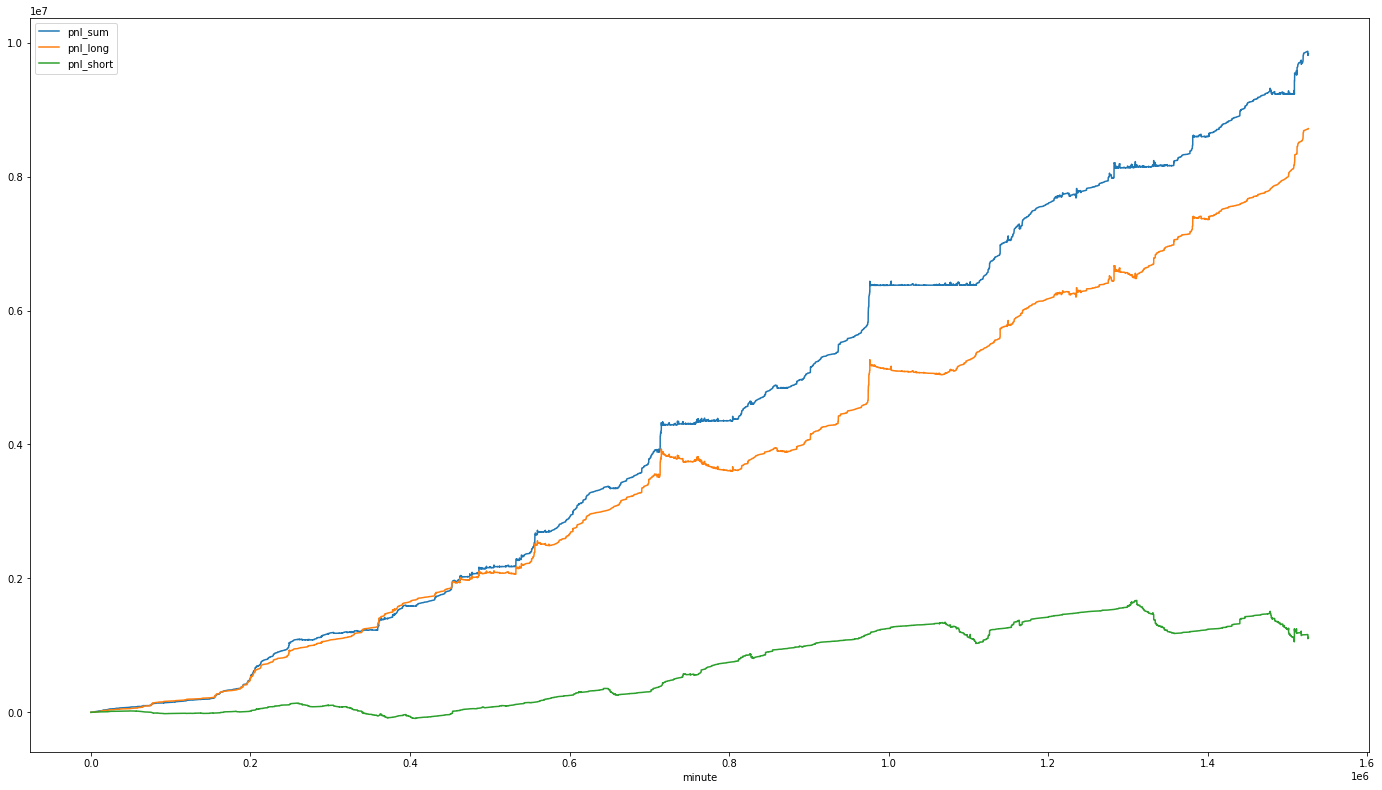

In [16]:
plot_pnls_long_short(sdf, fdf)

<AxesSubplot:xlabel='minute'>

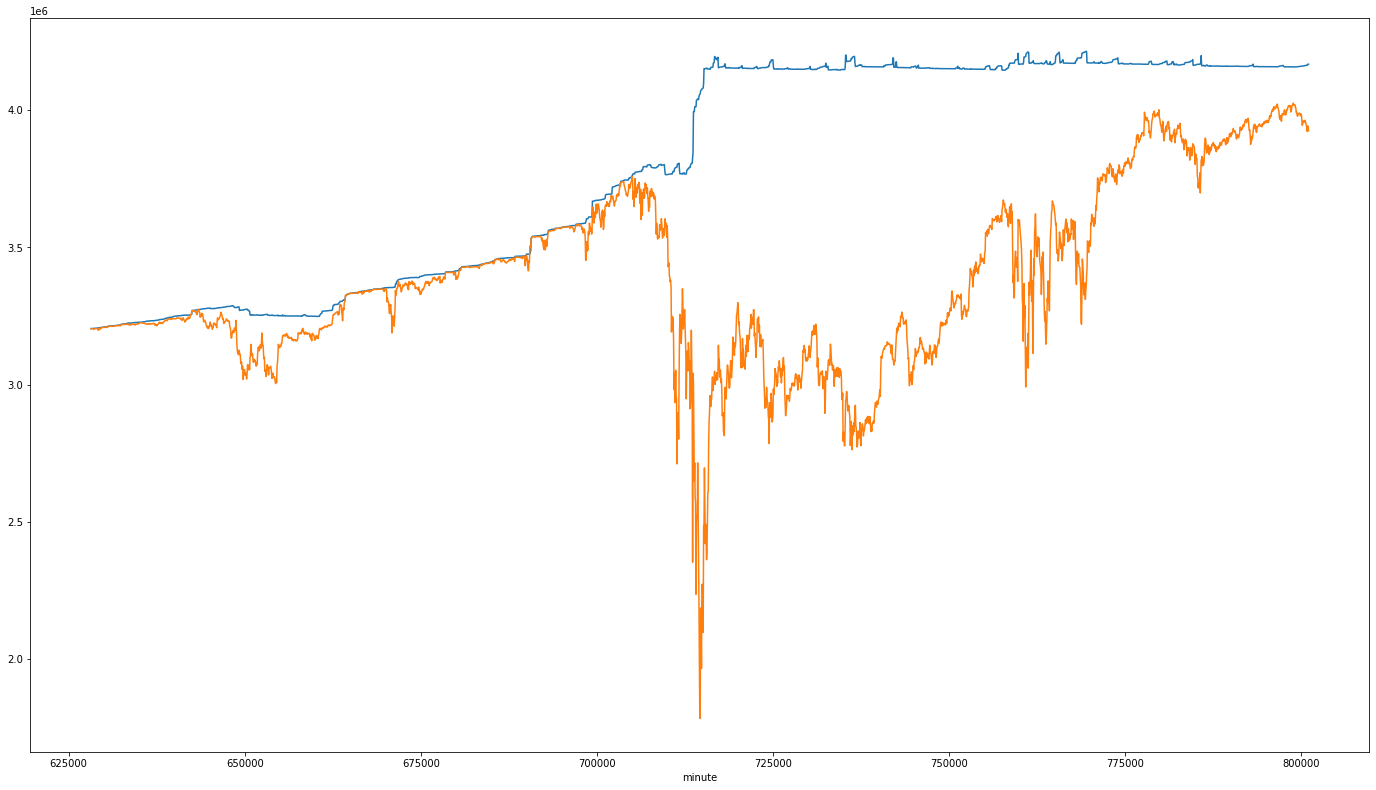

In [17]:
# inspect two months before and two months after location of worst drawdown
drawdowns = calc_drawdowns(sdf.equity)
worst_drawdown_loc = drawdowns.sort_values().iloc[:1].index[0]
wdls = worst_drawdown_loc - 60 * 24 * 30 * 2
wdle = worst_drawdown_loc + 60 * 24 * 30 * 2
sdfc = sdf.loc[wdls:wdle]
sdfc.balance.plot()
sdfc.equity.plot()

ADAUSDT


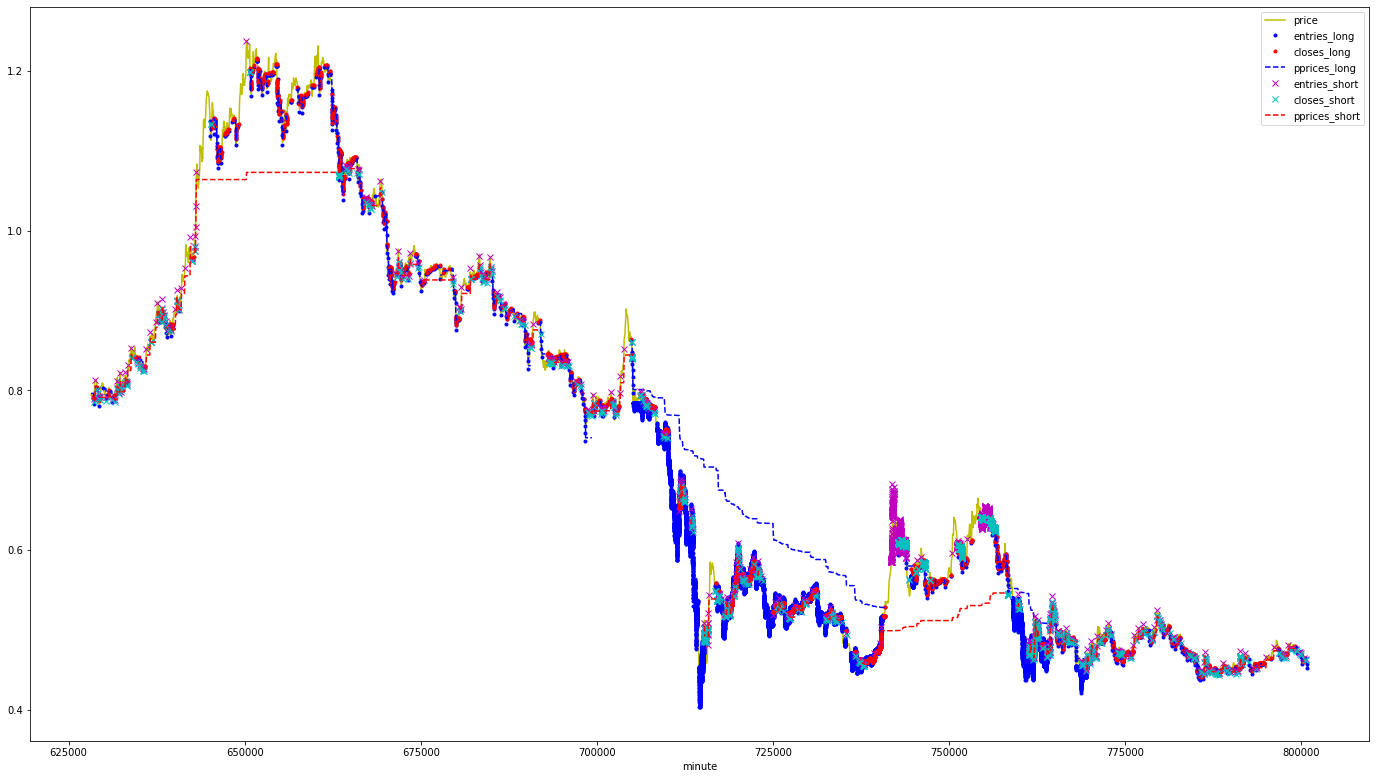

ALGOUSDT


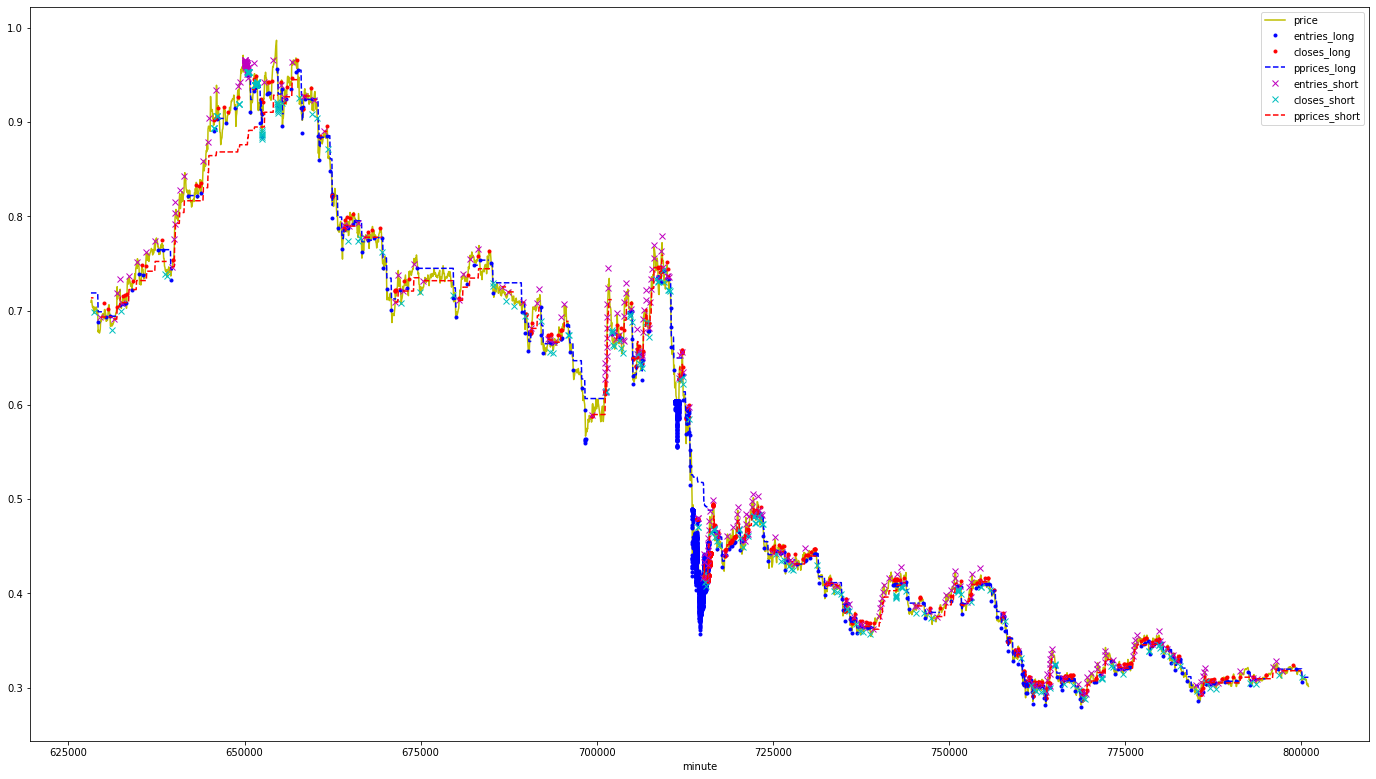

COMPUSDT


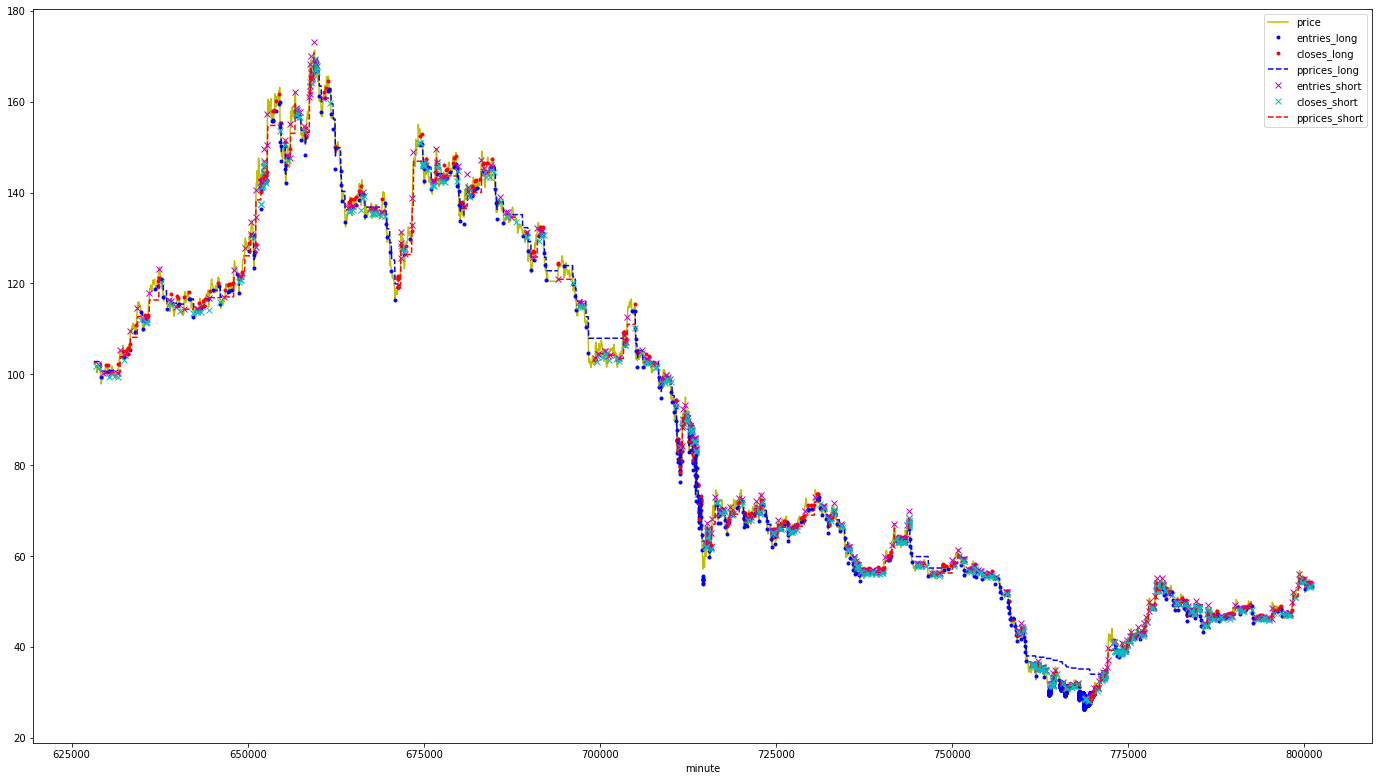

LINKUSDT


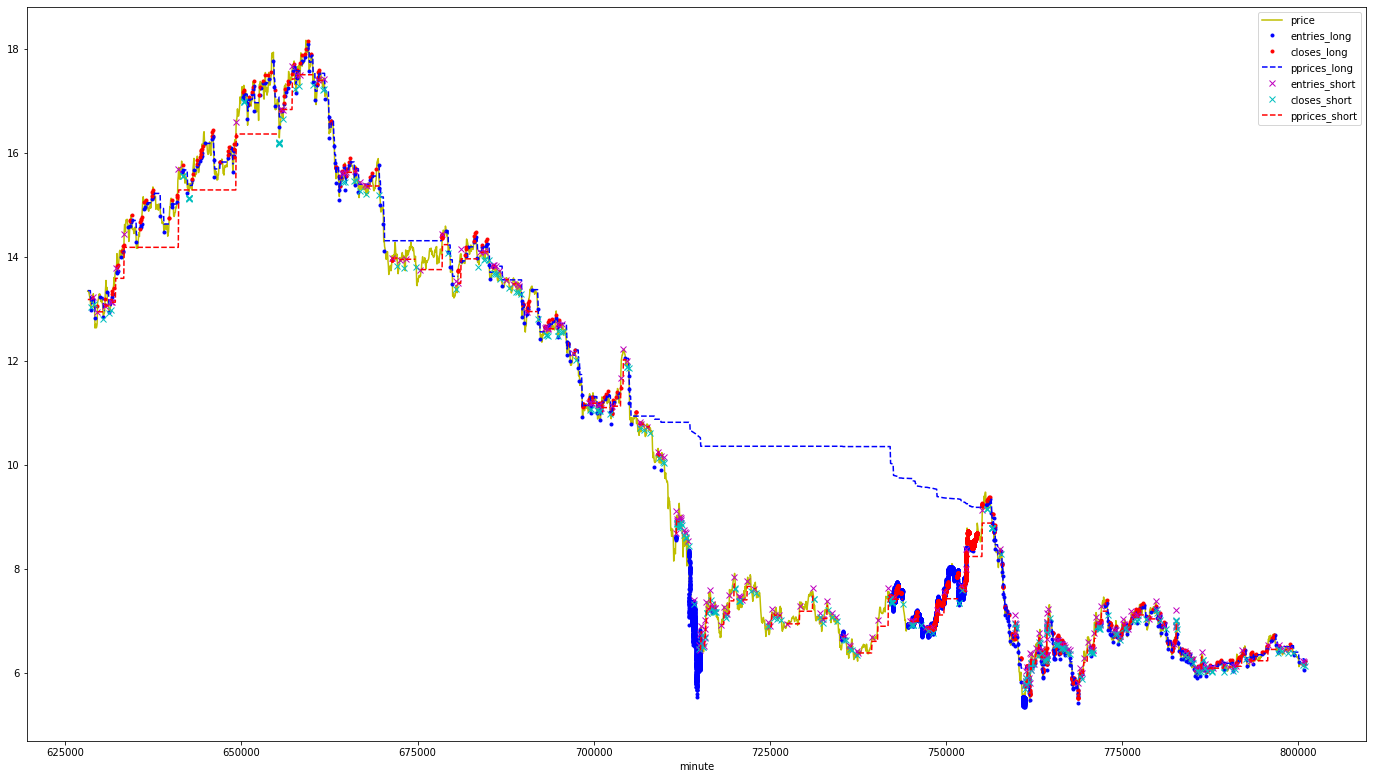

OMGUSDT


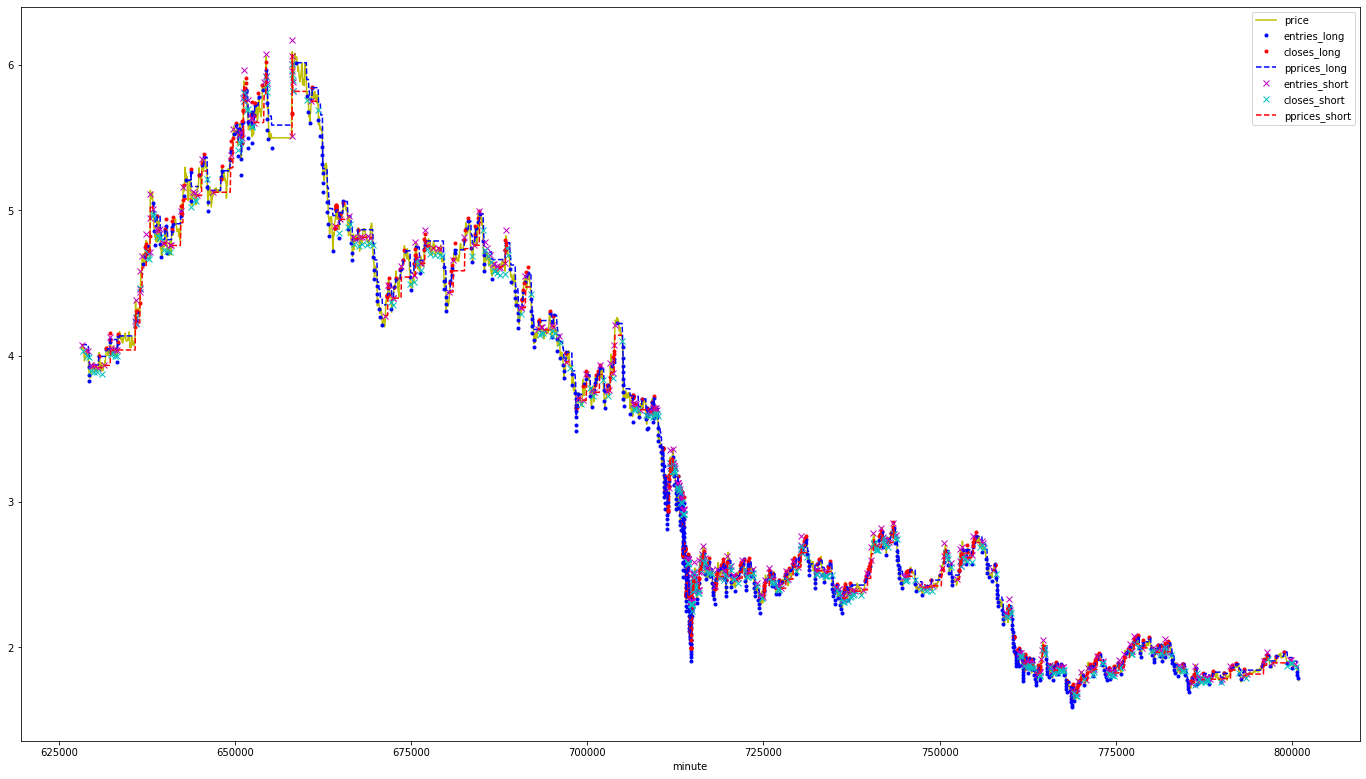

THETAUSDT


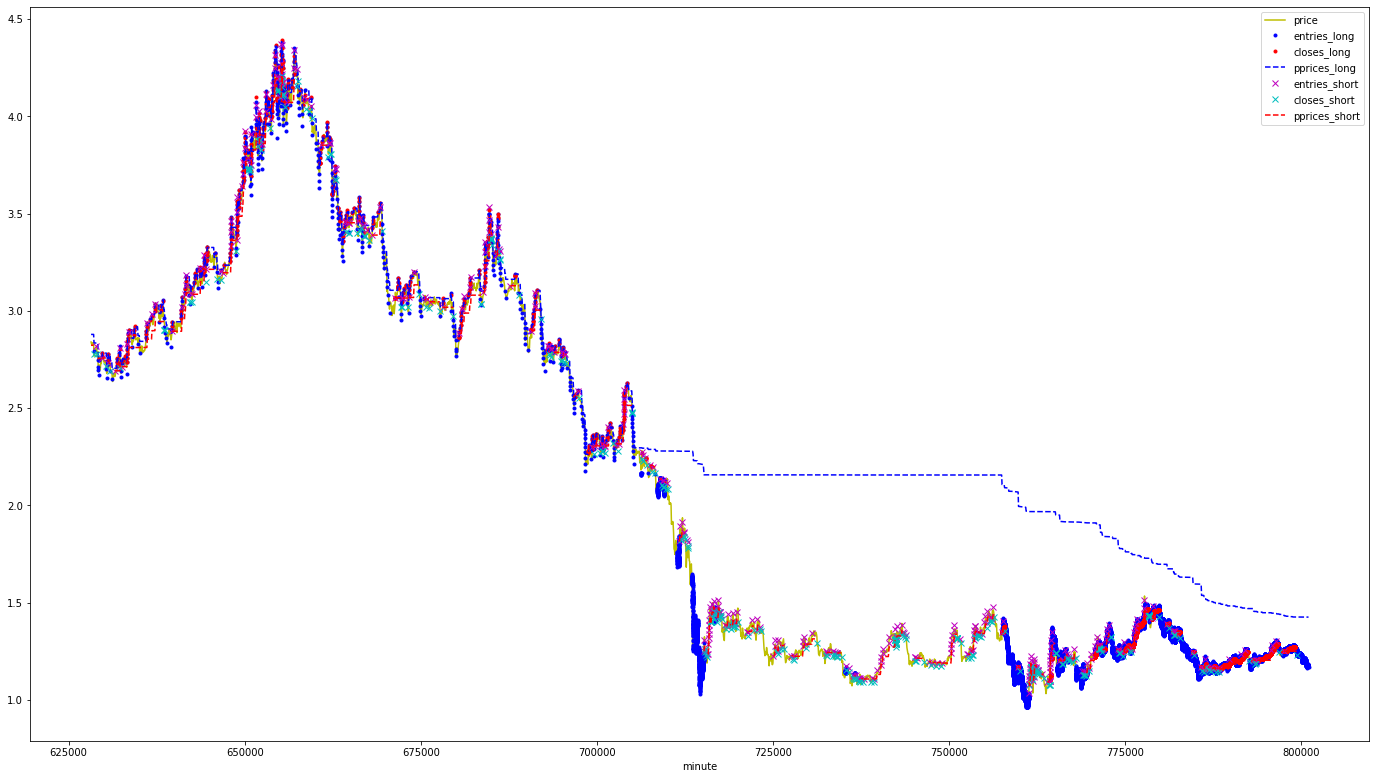

VETUSDT


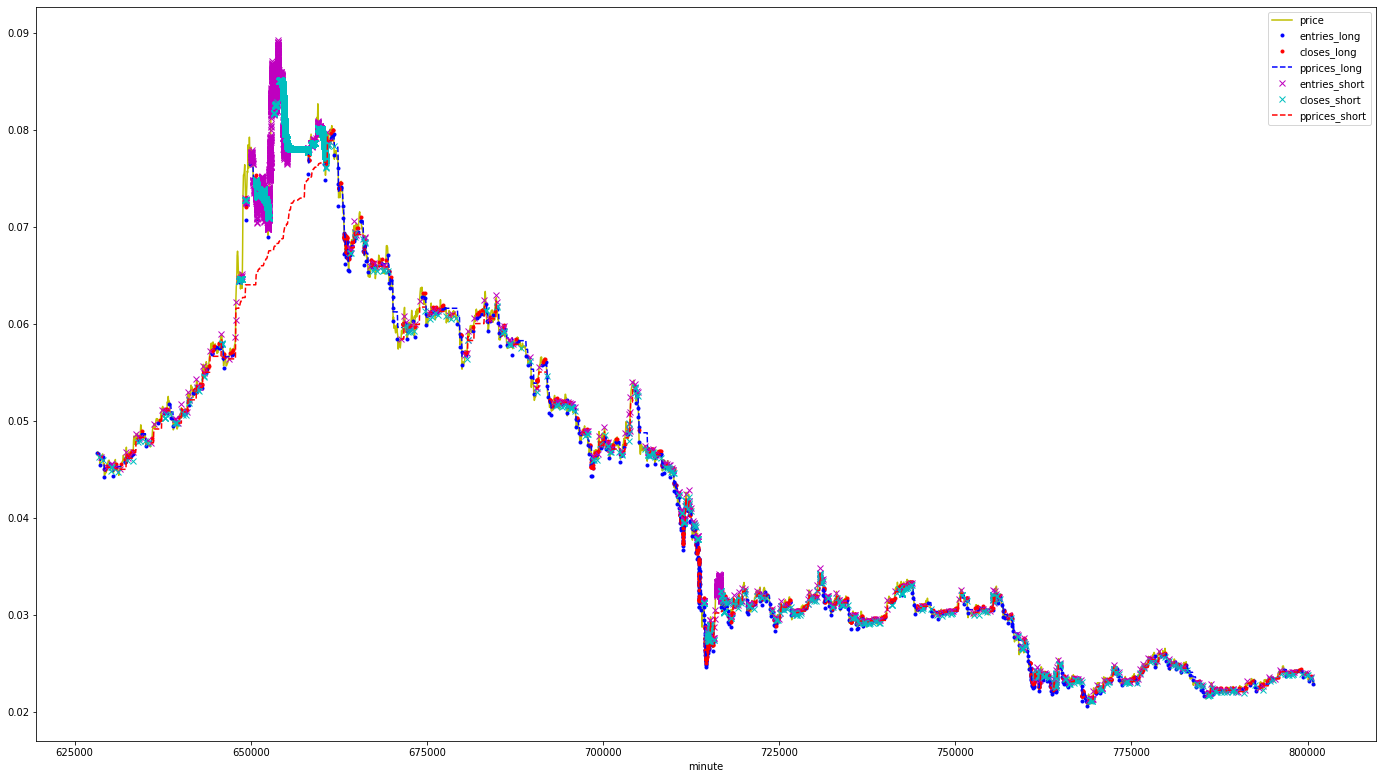

XTZUSDT


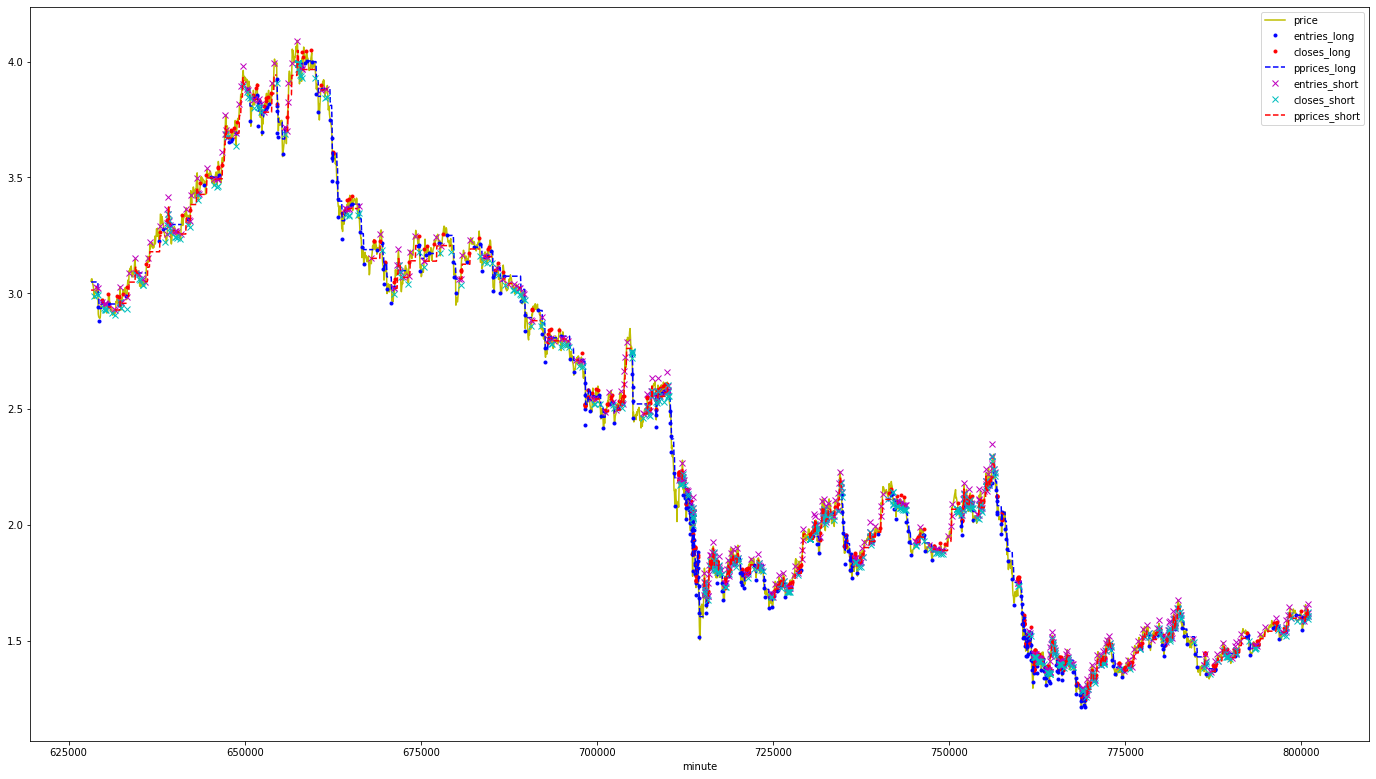

In [18]:
# inspect for each symbol
for symbol in symbols:
    print(symbol)
    plot_fills_multi(symbol, sdf.loc[wdls:wdle], fdf.loc[wdls:wdle]).show()

<AxesSubplot:xlabel='minute'>

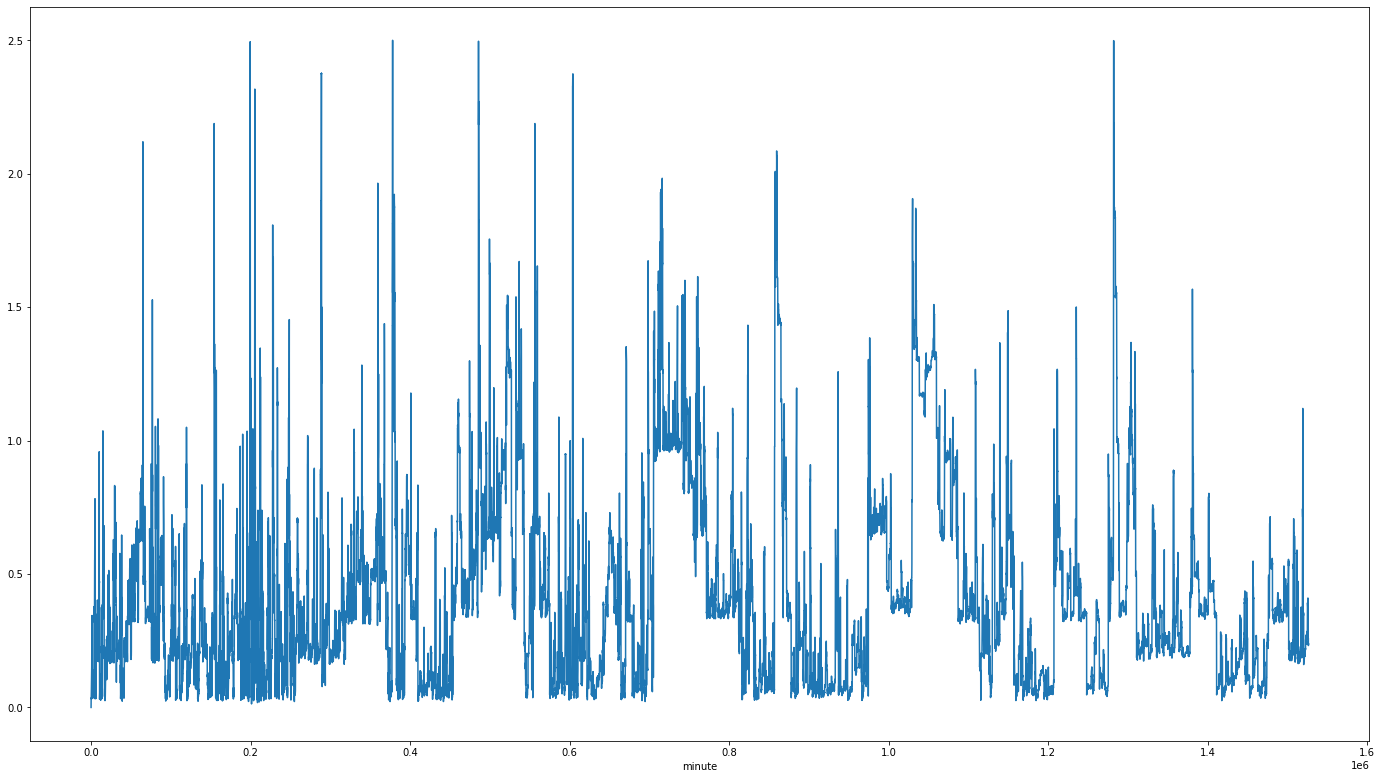

In [19]:
# exposures
sdf[[c for c in sdf.columns if "WE" in c]].sum(axis=1).plot()

In [20]:
higest_WE_loc_long = sdf[[c for c in sdf.columns if "WE_l" in c]].sum(axis=1).idxmax()
higest_WE_loc_short = sdf[[c for c in sdf.columns if "WE_s" in c]].sum(axis=1).idxmax()
higest_WE_loc_long, higest_WE_loc_short

(378060, 1303680)

<AxesSubplot:xlabel='minute'>

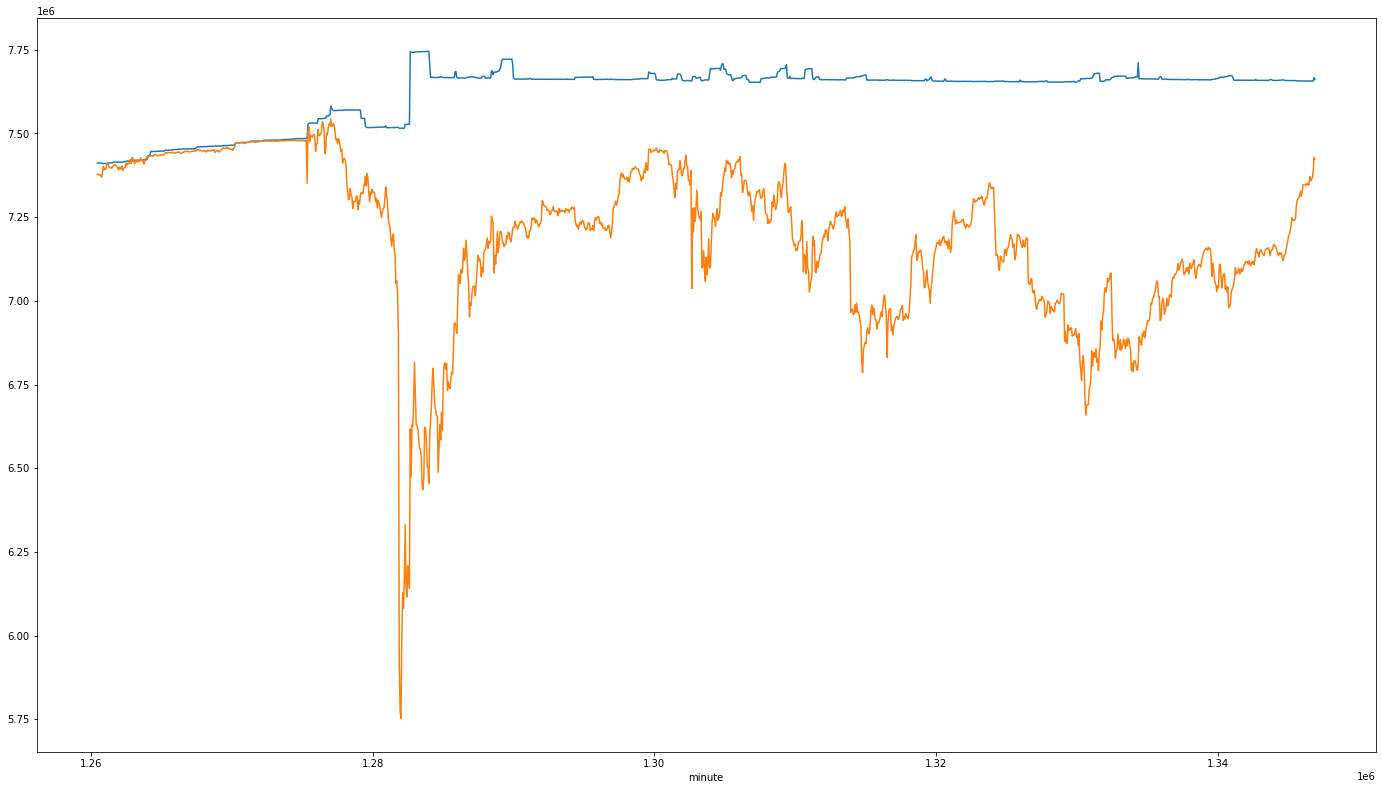

In [21]:
# inspect location of highest total exposure short
wdls = higest_WE_loc_short - 60 * 24 * 30
wdle = higest_WE_loc_short + 60 * 24 * 30
sdfc = sdf.loc[wdls:wdle]

sdfc.balance.plot()
sdfc.equity.plot()